> **Note:** In most sessions you will be solving exercises posed in a Jupyter notebook that looks like this one. Because you are cloning a Github repository that only we can push to, you should **NEVER EDIT** any of the files you pull from Github. Instead, what you should do, is either make a new notebook and write your solutions in there, or **make a copy of this notebook and save it somewhere else** on your computer, not inside the `sds` folder that you cloned, so you can write your answers in there. If you edit the notebook you pulled from Github, those edits (possible your solutions to the exercises) may be overwritten and lost the next time you pull from Github. This is important, so don't hesitate to ask if it is unclear.

# Exercise Set 2: Breast cancer

*February 14, 2020*

In this Exercise Set 2 we will work with the Breast Cancer dataset. You will implement and evaluate a number of different classifiers, and finally implement your own decision tree classifier.

**Load data**

In [6]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer

raw_data = load_breast_cancer()
data_features = pd.DataFrame(
    np.hstack([raw_data['data'], raw_data['target'].reshape(-1, 1)]),
    columns=raw_data['feature_names'].tolist() + ['benign']
)
data_features.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,benign
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


**Extract X and y**

In [7]:
X = raw_data['data']
y = raw_data['target']

<br>
<br>

## Random Forest

> **Ex. 2.1.1**: The performance of a random forest classifier is highly sensitive to hyper parameters. Therefore, you should be intimately familiar with what the most important ones do. For each point below, explain what the hyper parameter pertaining to `sklearn.ensemble.RandomForestClassifier` controls, and how setting it either too low or too high (or True/False) might hurt model performance:
1. `n_estimators`
2. `max_depth`
3. `max_features`
4. `bootstrap`


    - n_estimators is simply the number of trees in decision trees in the forrest. This also sets the number of samples the data is split into, since every tree is trained on its own sample/featureset.
    - max_depth is the maximum number of leafs (i.e. splits) in each tree in the forrest
    - max_features is the maximum number of featues concidered in each tree
    - bootstrap is a bool changing wheather the whole sample is used for the training of each tree or whether bootstrap sampling is used.


> **Ex. 2.1.2**: For `n_estimators > 1`how should one set the hyper-parameters `max_features` and `bootstrap` so that all the trees in the ensemble end up identical?

If max_features are set to the total number of features in the dataset, and bootstrap is false, then the same data and the same (all) features will be used in each tree.

> **Ex. 2.1.3**: Plot training and test accuracy of the random forest classifier as a function of `n_estimators`. Also indicate with a horizontal line (e.g. use `plt.axhline`) where the baseline accuracy lies (always guessing for majority class). Comparing and training and test performance, can you say something abotu how your model performs? And how does it perform relative to baseline? Report your maximum testing accuracy.
>
> *Hints: Use `StratifiedShuffleSplit` with the `cross_validate` method and give the latter the argument `return_train_score=True` to assess both training and test scores during cross validation. Also, you could let `n_estimators` vary on a logarithmic scale (like `np.logspace(np.log10(5), np.log10(500), 20)`) and log-scale the x-axis in your plot (`plt.xscale('log')`).*

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate
# baseline
dclf = DummyClassifier(strategy="most_frequent")
dclf.fit(X,y)
baseline = dclf.score(X,y)

# test
splits = StratifiedShuffleSplit(test_size=0.2, random_state=0)
train_scores = []
test_scores = []
n_estimators = np.logspace(np.log10(5), np.log10(500), 20)

for n in n_estimators:
    clf = RandomForestClassifier(n_estimators=int(n))
    score =cross_validate(clf,
                          X=X,
                          y=y,
                          cv=splits,
                          return_train_score=True,
                          n_jobs=-1)
    test_scores.append(score['test_score'].mean())
    train_scores.append(score['train_score'].mean())

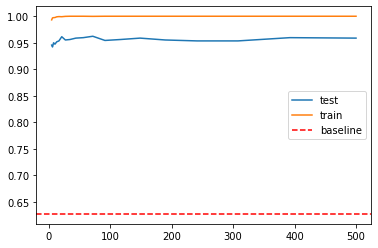

In [72]:
%matplotlib inline
import matplotlib

result = pd.DataFrame({'test':test_scores, 'train':train_scores}, index=n_estimators)
plt = result.plot()
plt.axes.axhline(y=baseline,label='baseline',c='r',ls='--')
plt.legend()

## Boosting

> **Ex. 2.2.1**: Repeat Ex. 2.1.3, but using AdaBoost. Do you notice any performance difference?

In [75]:
from sklearn.ensemble import AdaBoostClassifier
train_scores2 = []
test_scores2 = []
for n in n_estimators:
    clf = AdaBoostClassifier(n_estimators=int(n))
    score =cross_validate(clf,
                          X=X,
                          y=y,
                          cv=splits,
                          return_train_score=True,
                          n_jobs=-1)
    test_scores2.append(score['test_score'].mean())
    train_scores2.append(score['train_score'].mean())

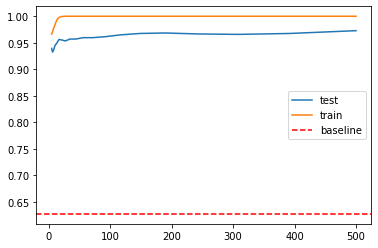

In [76]:
result = pd.DataFrame({'test':test_scores2, 'train':train_scores2}, index=n_estimators)
plt = result.plot()
plt.axes.axhline(y=baseline,label='baseline',c='r',ls='--')
plt.legend()

## Gradient boosting

> **Ex. 2.2.1**: Repeat Ex. 2.1.3, but using `sklearn.ensemble.GradientBoostingClassifier` with trees of depth 1. Do you notice any performance difference?

In [77]:
from sklearn.ensemble import GradientBoostingClassifier
train_scores3 = []
test_scores3 = []
for n in n_estimators:
    clf = GradientBoostingClassifier(n_estimators=int(n), max_depth=1)
    score =cross_validate(clf,
                          X=X,
                          y=y,
                          cv=splits,
                          return_train_score=True,
                          n_jobs=-1)
    test_scores3.append(score['test_score'].mean())
    train_scores3.append(score['train_score'].mean())

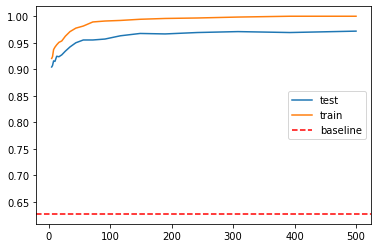

In [78]:
result = pd.DataFrame({'test':test_scores3, 'train':train_scores3}, index=n_estimators)
plt = result.plot()
plt.axes.axhline(y=baseline,label='baseline',c='r',ls='--')
plt.legend()

## Decision tree mechanism

Here you will be manually implementing the decision tree mechanism across a number of connected exercises.

>**Ex. 2.3.1**: Find the best feature to split on. There are many ways to do this, and we will be very practical about this and use the Pearson correlatio coefficient between a feature and the outcome, as an indicator of goodness.
Therefore, write a function that takes your input data `data_features` as input and returns the name of the feature that has the highest absolute (positive or negative) correlation with the outcome.
Use this function on your data to find the best initial feature to split on.
>
> *Hint: You can use `scipy.stats.spearmanr` to compute the correlation coefficient. E.g. to compute the absolute correlation coefficient between two variables `a` and `b`, I would write `abs(spearmanr(a, b)[0])`.*

>**Ex. 2.3.2**: Read about [Shannon entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)). Write a function that computes the Shannon-entropy of a probability vector. Compute the Shannon entropy of `p=[0.4, 0.6]`.

>**Ex. 2.3.3**: Compute split entropy. 
1. Write a function `split_data_on(data, feature, thr)` that takes as input your data, initially `data_features`, a threshold, `thr`, and a feature, `feature`, and then splits the data into two subsets (also `pandas.Dataframe`s), `data0` and `data1`, where samples in `data0` have `data[feature] > thr` and samples in `data1` have `data[feature] > thr`. Use it to split `data_features` on the 'worst perimeter' feature at 105.9, to create two new variables `data0` and `data1` and print their number of rows.
1. Write another function `outcome_entropy(data)` that computes the entropy of outcomes ('benign' column), given a subset. Print the entropies of `data0` and `data1`.
2. Write a final function `split_entropy(data0, data1)` that uses the previous function to compute the split entropy (i.e. weighted average of both resulting subsets). Compute the split entropy.

>**Ex. 2.3.4**: Find the optimal split threshold. Write a function called `optimal_threshold(data, feature)`
that takes as input your data and a feature, and loops over all possible splits for a feature such as to find and return the minimum split entropy and associated threshold. Execute it for 'worst perimeter' does this match up with your results from 2.3.2?

>**Ex. 2.3.5**: Now you have (1) a function that finds the best feature to split on, given dataframe of data, and (2) another function that computes the threshold at which to split it into two new subsets. Implement the decision tree mechanism, and print the maximum entropy path.
>1. Implement the following pseudocode and print the output:<br><br>
>Step 0. Initially, set `data = data_features`.<br>
>Step 1. Find the feature that gives the lowest split entropy for `data` (use `best_feature`). Print the name of the feature.<br>
>Step 2. Split `data` *on the optimal threshold* of that feature, to produce `data0` and `data1` (use `optimal_threshold` to find the optimal threshold and then use `split_data_on` to actually split it). Print the entropy of each, as well as their weighted avg. entropy (i.e. the split entropy).<br>
>Step 3. Overwrite the `data` variable with either `data0` or `data1`, depending on which has the highest entropy.<br>
>Step 4. Stop if there are less than 5 datapoints in `data`. Otherwise start over from 1.<br><br>
>My output looks [like this](https://github.com/abjer/sds_eml_2020/blob/master/material/session_2/solution_2.3.5.1.png) for the first five splits.<br><br>
>
>2. Comment on decision path your code takes: How many splits are there? Does average entropy always decrease? Anything else worth commenting on?
>3. Train a `sklearn.tree.DecisionTreeClassifier` classifier on the dataset. Initiate the classifier with `criterion='entropy'`. What are the most important features of this classifier? How does this line up with the order of splits you just printed (a comment is fine)?

>**Challenge!**: Finish the implementation and write a piece of code that makes all splits at each level, level-for-level for 4 levels.
You can store the tree as a nested dictionary with a structure like:
>
>        mytree = {
>            'majority': 1,
>            'feature': 'worst perimeter',
>            'threshold': 105.9,
>            'leafs': {
>                {
>                    'less than or equal to': {
>                        'majority': 1,
>                        'feature': 'mean concave points',
>                        'threshold': 0.05102,
>                        'leafs': {...}
>                    },
>                    'greater than': {
>                        'majority': 0,
>                        'feature': 'mean concave points',
>                        'threshold': 0.04835,
>                        'leafs': {...}
>                    }
>                }
>            }
>        }
>
> ... which will allow you to write another bit of code that takes an arbitrary data point and produces a prediction.
>
> *Note: Implementing and fitting a classifier manually is **no small accomplishment**! If you manage, you can easily add it to your Github
portfolio and brag about it in a Medium blog post (if written well will probably get picked up by 'Towards
Data Science' or similar), on LinkedIn or Twitter. To quote Edison: "Opportunity is missed by most people because it is dressed in overalls and looks like work."*